In [1]:
!pip install matplotlib==3.8.4

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

2025-03-27 19:48:37.716980: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 19:48:37.728691: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 19:48:37.750621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743119317.783381   96915 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743119317.794696   96915 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743119317.834782   96915 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
model_name = "movenet_thunder" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

E0000 00:00:1743119325.483791   96915 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743119325.484591   96915 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
!curl -o input_image1.jpeg "https://www.fcbarcelona.com/fcbarcelona/photo/2021/01/31/3c55a19f-dfc1-4451-885e-afd14e890a11/mini_2021-01-31-BARCELONA-ATHLETIC-BILBAOI-30.JPG" --silent
!curl -o input_image2.jpeg "https://talksport.com/wp-content/uploads/sites/5/2019/04/GettyImages-1134535138.jpg" --silent


In [5]:
def load_and_preprocess(image_path, target_size=(256, 256)):  # Change target size if needed
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB
    image = tf.image.resize_with_pad(image, target_size[0], target_size[1])  # Resize while maintaining aspect ratio



    # Convert to float32 and normalize to [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  
    return image


In [6]:
# Load the input image.
image_path1 = "input_image1.jpeg"
image1 = tf.io.read_file(image_path1)
image1 = tf.image.decode_jpeg(image1)

image_path2 = "input_image2.jpeg"
image2 = tf.io.read_file(image_path2)
image2 = tf.image.decode_jpeg(image2)


# Load and preprocess images
image1 = load_and_preprocess(image_path1)
image2 = load_and_preprocess(image_path2)



In [7]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}


CONNECTIONS = [
    ["nose", "left_eye"],
    ["nose", "right_eye"],
    ["left_eye", "left_ear"],
    ["right_eye", "right_ear"],
    ["left_shoulder", "right_shoulder"],
    ["left_shoulder", "left_elbow"],
    ["right_shoulder", "right_elbow"],
    ["left_elbow", "left_wrist"],
    ["right_elbow", "right_wrist"],
    ["left_shoulder", "left_hip"],
    ["right_shoulder", "right_hip"],
    ["left_hip", "left_knee"],
    ["right_hip", "right_knee"],
    ["left_knee", "left_ankle"],
    ["right_knee", "right_ankle"]
]



# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
    """Returns high confidence keypoints and edges for visualization.

    Args:
        keypoints_with_scores: A numpy array with shape [num_instances, 17, 3] 
            representing the keypoint coordinates and scores returned from MoveNet.
        height: height of the image in pixels.
        width: width of the image in pixels.
        keypoint_threshold: minimum confidence score for a keypoint to be visualized.

    Returns:
        A tuple (keypoints_xy, edges_xy, edge_colors) containing:
            * keypoints_xy: coordinates of all detected keypoints.
            * edges_xy: coordinates of all skeleton edges.
            * edge_colors: colors for each edge.
    """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    
    num_instances = keypoints_with_scores.shape[0]
    
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[idx, :, 1]
        kpts_y = keypoints_with_scores[idx, :, 0]
        kpts_scores = keypoints_with_scores[idx, :, 2]
        
        kpts_absolute_xy = np.stack(
            [width * kpts_x, height * kpts_y], axis=-1)
        keypoints_all.append(kpts_absolute_xy)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (kpts_scores[edge_pair[0]] > keypoint_threshold and
                kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start, y_start = kpts_absolute_xy[edge_pair[0]]
                x_end, y_end = kpts_absolute_xy[edge_pair[1]]
                keypoint_edges_all.append(np.array([[x_start, y_start], [x_end, y_end]]))
                edge_colors.append(color)

    keypoints_xy = np.concatenate(keypoints_all, axis=0) if keypoints_all else np.zeros((0, 2))
    edges_xy = np.stack(keypoint_edges_all, axis=0) if keypoint_edges_all else np.zeros((0, 2, 2))
    
    return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

def label_keypoints(KEYPOINT_DICT, keypoints_with_scores):
    labeled_keypoints = dict()
    
   
    

    for i, part in enumerate(KEYPOINT_DICT):

        labeled_keypoints[part] = {
            "coor": keypoints_with_scores[0][i][:2], 
            "confidence_score": keypoints_with_scores[0][i][2]  
        }

    
    return labeled_keypoints


def label_joints(keypoints, CONNECTIONS):
    joints = {}
    for joint_pair in CONNECTIONS:
        point1 = keypoints[joint_pair[0]]["coor"]
        point2 = keypoints[joint_pair[1]]["coor"]

        joint_vector = {"x": point1[0] - point2[0], "y": point1[1] - point2[1]}

        joints[f"{joint_pair[0]}/{joint_pair[1]}"] = joint_vector
    return joints


import numpy as np

def compare_joints(joints1, joints2):
    angle_differences = {}
    
    for joint_key in joints1.keys():
        if joint_key in joints2:  # Ensure the joint exists in both images
            vec1 = np.array([joints1[joint_key]["x"], joints1[joint_key]["y"]])
            vec2 = np.array([joints2[joint_key]["x"], joints2[joint_key]["y"]])
            
            # Compute the angle between the vectors
            dot_product = np.dot(vec1, vec2)
            norm1 = np.linalg.norm(vec1)
            norm2 = np.linalg.norm(vec2)
            
            if norm1 > 0 and norm2 > 0:  # Avoid division by zero
                cosine_similarity = dot_product / (norm1 * norm2)
                angle_difference = np.arccos(np.clip(cosine_similarity, -1.0, 1.0))  # Get angle in radians
                angle_differences[joint_key] = np.degrees(angle_difference)  # Convert to degrees
            else:
                angle_differences[joint_key] = None  # If one of the vectors is zero, comparison is invalid
    
    return angle_differences


/tmp/ipykernel_96915/2072416756.py:174: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_96915/2072416756.py:174: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


<Figure size 1200x600 with 0 Axes>

Joint pair angle difference: nose/left_eye, Vector: 7.789210319519043
Joint pair angle difference: nose/right_eye, Vector: 7.006894588470459
Joint pair angle difference: left_eye/left_ear, Vector: 3.9318366050720215
Joint pair angle difference: right_eye/right_ear, Vector: 0.49850085377693176
Joint pair angle difference: left_shoulder/right_shoulder, Vector: 0.9875454306602478
Joint pair angle difference: left_shoulder/left_elbow, Vector: 16.814725875854492
Joint pair angle difference: right_shoulder/right_elbow, Vector: 3.5116782188415527
Joint pair angle difference: left_elbow/left_wrist, Vector: 27.9296875
Joint pair angle difference: right_elbow/right_wrist, Vector: 16.049015045166016
Joint pair angle difference: left_shoulder/left_hip, Vector: 4.530039310455322
Joint pair angle difference: right_shoulder/right_hip, Vector: 3.8100738525390625
Joint pair angle difference: left_hip/left_knee, Vector: 20.357507705688477
Joint pair angle difference: right_hip/right_knee, Vector: 6.9001

/tmp/ipykernel_96915/2072416756.py:174: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_96915/2072416756.py:174: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


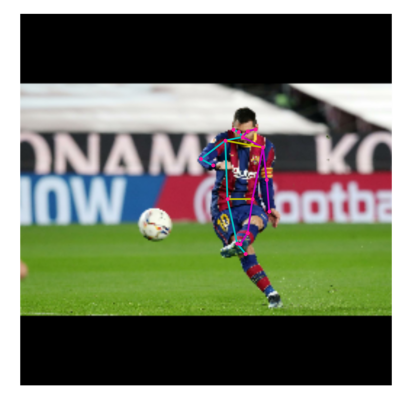

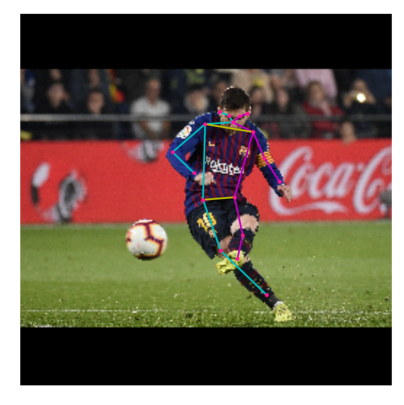

In [ ]:
image1 = load_and_preprocess(image_path1)
image2 = load_and_preprocess(image_path2)

# Add a batch dimension to each image (batch size of 1)
image1_batch = tf.expand_dims(image1, axis=0)  # Shape becomes (1, height, width, channels)
image2_batch = tf.expand_dims(image2, axis=0)  # Shape becomes (1, height, width, channels)

# Process each image one by one
outputs1 = movenet(tf.constant(image1_batch, dtype=tf.float32))
outputs2 = movenet(tf.constant(image2_batch, dtype=tf.float32))


# Extract keypoints for both images (first batch dimension is 1)
keypoints_with_scores1 = outputs1[0]  # Shape: [num_keypoints, 3]
keypoints_with_scores2 = outputs2[0]  # Shape: [num_keypoints, 3]

# Label keypoints for each image
labeled_keypoints1 = label_keypoints(KEYPOINT_DICT, keypoints_with_scores1)
labeled_keypoints2 = label_keypoints(KEYPOINT_DICT, keypoints_with_scores2)

# Extract joints for comparison between two images
joints1 = label_joints(labeled_keypoints1, CONNECTIONS)
joints2 = label_joints(labeled_keypoints2, CONNECTIONS)

# Compare joints and calculate angle differences
angle_differences = compare_joints(joints1, joints2)

# Visualize keypoints on both images
image_with_keypoints1 = draw_prediction_on_image(image1.numpy(), keypoints_with_scores1)
image_with_keypoints2 = draw_prediction_on_image(image2.numpy(), keypoints_with_scores2)

# Display the images with keypoints overlaid
plt.figure(figsize=(12, 6))

# Image 1 with keypoints
plt.subplot(1, 2, 1)
plt.imshow(image_with_keypoints1)
plt.title("Image 1 with Keypoints")

# Image 2 with keypoints
plt.subplot(1, 2, 2)
plt.imshow(image_with_keypoints2)
plt.title("Image 2 with Keypoints")

plt.show()

# Print the angle differences between joints in both images

for joint_pair, joint_vector in angle_differences.items():
    print(f"Joint pair angle difference: {joint_pair}, Vector: {joint_vector}")# Display the final output image with keypoints on image1
display_image1 = tf.expand_dims(image1, axis=0)
display_image1 = tf.cast(tf.image.resize_with_pad(display_image1, 1280, 1280), dtype=tf.int32)
output_overlay1 = draw_prediction_on_image(np.squeeze(display_image1.numpy(), axis=0), keypoints_with_scores1)

# Display the output overlay for image1
plt.figure(figsize=(5, 5))
plt.imshow(output_overlay1)
_ = plt.axis('off')

# Display the final output image with keypoints on image2
display_image2 = tf.expand_dims(image2, axis=0)
display_image2 = tf.cast(tf.image.resize_with_pad(display_image2, 1280, 1280), dtype=tf.int32)
output_overlay2 = draw_prediction_on_image(np.squeeze(display_image2.numpy(), axis=0), keypoints_with_scores2)

# Display the output overlay for image2
plt.figure(figsize=(5, 5))
plt.imshow(output_overlay2)
_ = plt.axis('off')
